# Transfer Learning with VGG

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
import numpy as np

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

### Description

Transfer leaning using the VGG convolutional neural network (CNN) for flower classification.

### Content

### GPU

Training a convolutional neural network (CNN) can quickly become computationally expensive, especially for large images and a large number of convolutional filters. For this reason we should offload the forward pass and backpropagation to a graphic processing unit (GPU), if it is available. We can write general code that works both on a CPU and a GPU buy defining a `device`:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Data Set

### Data Transformation

We want to use a pre-trained VGG architecture in combination with transfer learning in order to classify flower images. In order to use the data in our neural network, we need to transform the images into `torch.Tensor`s. Additionally, the VGG-16 architecture we will use takes images of size 224x224 with the following normalisation: 

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(mean=mean,
                                 std=std)

In order to resize the images we use `RandomResizedCrop` which allows a bit of data augmentation:

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    normalize])

 The training and test examples are separated in the `test/` and `train/` folders, which in turn contain sub-folders named after the classes of flowers. The [`ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class allows to easily load such dataset.

In [ ]:
dataroot = "data/"

traindir = os.path.join(dataroot, 'train')
testdir = os.path.join(dataroot, 'test')

trainset = datasets.ImageFolder(traindir, transform=transform)
testset = datasets.ImageFolder(testdir, transform=transform)

The amount of data in this dataset is not very large, therefore transfer learning is a very convenient technique for this dataset:

In [ ]:
print(f"Number of training examples: {len(trainset)}")
print(f"Number of testing examples: {len(testset)}")

Number of training examples: 3130
Number of testing examples: 540


### Data Loaders

We can now define a `torch.utils.data.DataLoader` which loads the datasets in randomly shuffled batches:

In [ ]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Finally, we can define iterators to iterate over `tranloader`, and `testloader` batches:

In [ ]:
trainiter = iter(trainloader)
testiter = iter(testloader)

#### Visualizing Images and Labels

First, let's define a dictionary mapping labels (numbers from 0 to 4 denoting one of the flower classes) to the acutal classes names:

In [ ]:
classes = classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

label_to_name = { 
    i : name 
    for i, name in enumerate(classes) 
}

print(label_to_name)

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}


Then we can visualise a batch of images. PyTorch store images with in the `C x H x W` convention (where C is number of channels, H the image height and W the image width) while `matplotlib` uses the `H x W x C` convention. This means that we have to transpose our tensor from `C x H x W` to  `H x W x C`.

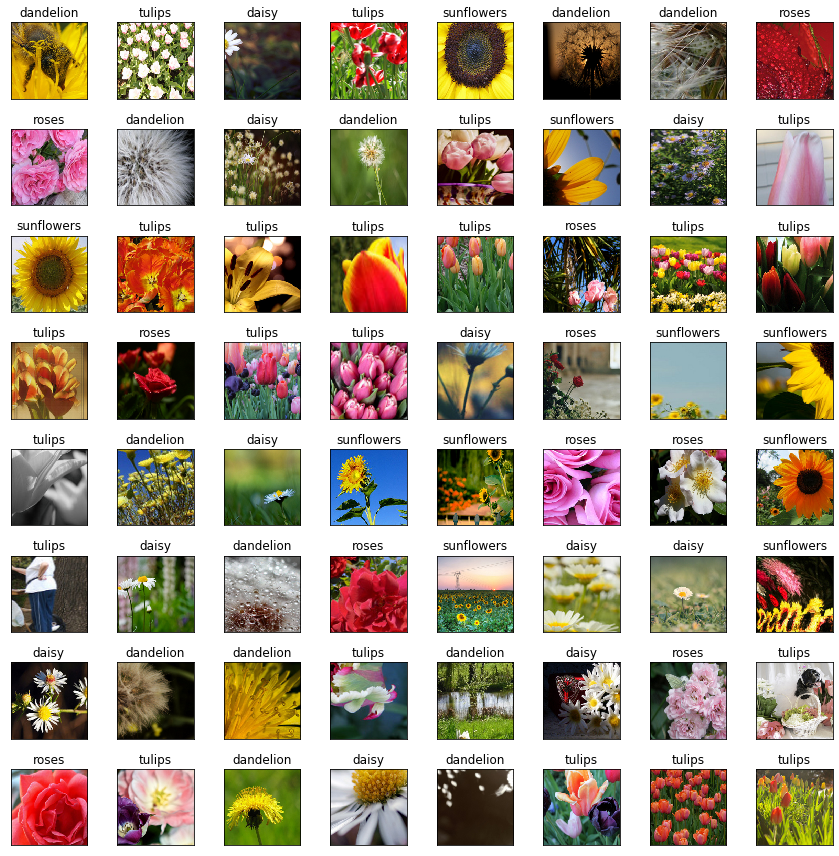

In [ ]:
images, labels = next(trainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy().squeeze()
    for i in range(3):
        img[i,:,:] = img[i,:,:] * std[i] + mean[i]

    # Transpose image from C x H x W to H x W x C
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
    # Get name
    name = label_to_name[labels[idx].item()]
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Pre-Trained VGG-16

We want to use the pre-trained VGG-16 architecture provided by `torchvision.models`. In particular, we want to freeze all weights of the CNN and only replace the last fully connected layer with a layer with the correct number of classes.

Let's start by downloading the VGG16 architecture and inspecting it:

In [ ]:
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

As expected, we have a feature extractor (convolutional layers) and a classifier (fully connected layers). The classifier currently deals with 1000 classes. We can now freeze all the parameters of the network and replace the last linear layer (index 6):

In [ ]:
# Freeze VGG-16 parameters
for param in model.features.parameters():
    param.requires_grad = False

# Extract number of input features in th last layer
n_inputs = model.classifier[6].in_features

# Substitute last layer with a new one
# The number of outputs is the number of classes
model.classifier[6] = nn.Linear(n_inputs, len(classes))

In [ ]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Test Forward Pass

In order to check that our model definition works correctly, we can try to propagate on batch of images through the network. It is important to notice that the data from the `DataLoader` has to be moved to the `device` as well (since the model is now working on the `device`).  We can also plot the class probabilities of this untrained model:

In [ ]:
def showclassp(images, labels, model, misclassified=False):
    """
    Plot class probabilities for a batch of images and labels.
    """
    
    from collections import namedtuple
    
    # Define named tuple for misclassified images
    # Clearer for printing, reporting batch index and true label
    Misclassified = namedtuple("Misclassified", "index true_label")
    
    # Defint a figure
    fig = plt.figure(figsize=(14,12))
    
    # List of missclassified systems
    failed = []
    
    # Compute predictions
    with torch.no_grad(): # Do not track gradients
            # Perform forward pass
            out = model(images)
            
            # Compute class probabilities
            # The model returns log-probabilities
            p = F.softmax(out).cpu().numpy()
    
    # Loop over images and labels in a batch
    for idx in range(64):
        
        # Create subplot
        ax = fig.add_subplot(8, 8, idx + 1, xticks=range(5), yticks=[0, 1])

        # Plot all class probabilities for given image
        for i in range(5):
            if labels[idx] == i:
                if labels[idx] == np.argmax(p[idx]):
                    plt.bar(i, p[idx,i], color="g")
                else:
                    plt.bar(i, p[idx,i], color="r")
                    
                    # Append misclassified sample
                    failed.append(Misclassified(idx, np.argmax(p[idx])))
            else:
                plt.bar(i, p[idx,i], color="k")
        plt.ylim([0,1.25])
        
        ax.set_xticklabels(label_to_name.values(), rotation=90, fontdict={"fontsize": 7.5})
        
        name = label_to_name[labels[idx].item()]
        ax.set_title(name, fontdict={"fontsize": 12})

    plt.tight_layout()
    plt.show()
    
    return failed if misclassified else  None

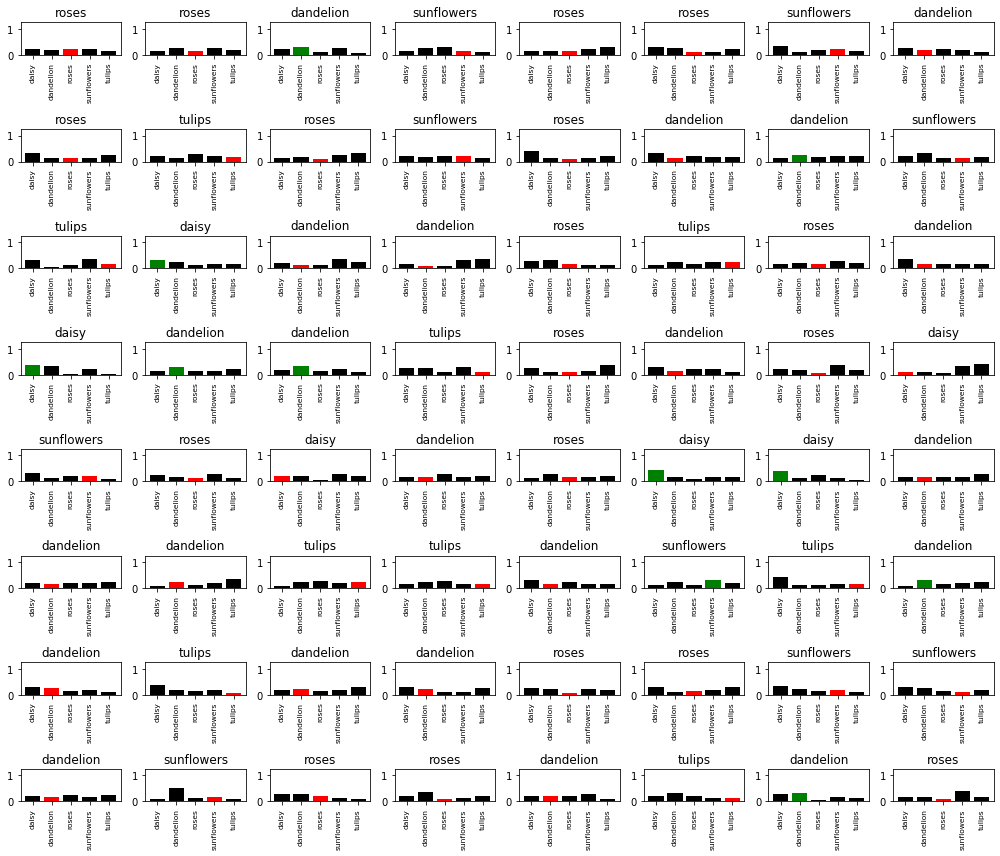

In [ ]:
# Extract first batch of images
images, labels = next(trainiter)

# Move images and labels to the GPu
images, labels = images.to(device), labels.to(device)

# Perform forward propagation
# Show class probabilities
showclassp(images, labels, model)

### Training

In order to train the model we have to define a loss function. Since our model output comes from a linear layer, we need to use the cross entropy loss:

In [ ]:
ce_loss = nn.CrossEntropyLoss()

Then we need to define an optimizer and link it to the model parameters. Here we use the [Adam optimizer](https://arxiv.org/abs/1412.6980).

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.003)

Finally we can train our network. In order to speedup the training loop we can use the `torch.no_grad()` context manager so that expensive gradient computations are avoided during the validation phase.

In [ ]:
from tqdm import tqdm

def train(model, optimizer, loss_function, epochs=15, device=device):
    """
    Train a model by ooptimizing a loss_function using the given optimizer.
    Model and data are moved to the set device.
    """

    import time

    # Move model to device
    model.to(device)

    train_losses = []

    # Loop over epochs
    for epoch in range(epochs):

        # Start epoch timer
        time_init = time.time()
        
        # Initialize total epoch loss
        epoch_loss = 0
        
        # Training
        for images, labels in tqdm(trainloader):

            # Move data to GPU
            images, labels = images.to(device), labels.to(device)
        
            # Initialize the gradients to zero
            optimizer.zero_grad()
            
            # Perform forward pass
            output = model(images)
            
            # Compute the loss
            loss = loss_function(output, labels)
            
            # Perform backpropagation
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Accumulate total epoch loss
            epoch_loss += loss.item()
                    
        # Store losses
        train_losses.append(epoch_loss/len(trainloader))

        # Stop epoch timer
        time_end = time.time()
                
        print(f"\n--- Epoch {epoch+1:2} ---")
        print(f"Train Loss: {train_losses[-1]:.5f}")
        print(f"Time: {time_end - time_init:.3f} s")
    
    return train_losses

In [ ]:
# Define the number of training epochs
epochs = 3


train_losses = train(model, optimizer, ce_loss, epochs, device)

  0%|          | 0/49 [00:00<?, ?it/s]--- Epoch  1 ---
Train Loss: 0.84435
Time: 1151.947 s
  0%|          | 0/49 [00:00<?, ?it/s]--- Epoch  2 ---
Train Loss: 1.10647
Time: 1125.777 s
100%|██████████| 49/49 [19:16<00:00, 23.61s/it]--- Epoch  3 ---
Train Loss: 1.38458
Time: 1156.821 s



## Testing the  Model

### Accuracy

In [ ]:
def accuracy(model, testloader, loss_function, device=device):
    
    from collections import defaultdict
    
    test_loss = 0.0
    
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    model.eval()
    
    with torch.no_grad(): 
        for images, labels in testloader:

            # Move data to GPU
            images, labels = images.to(device), labels.to(device)
                
            # Perform forward pass
            output = model(images)
                
            # Compute class probabilities
            p = F.softmax(output)
                
            # Compute the loss
            test_loss += loss_function(output, labels).item()
                
            # Get class of top prediction
            _, c = torch.max(p, dim=1) 
            
            correct = np.squeeze(c.eq(labels.data.view_as(c)).cpu().numpy())
            
            for i in range(len(labels)):
                label = labels.data[i].item()
                
                class_correct[label] += correct[i].item()
                class_total[label] += 1
           
    # Average test loss (per example)
    test_loss = test_loss/len(testloader.dataset)
    print(f"Test Loss: {test_loss:.5f}")
    
    total_correct = np.sum([c for _, c in class_correct.items()])
    total = np.sum([c for _, c in class_total.items()])
    
    accuracy = total_correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f} ({total_correct}/{total})\n")
    
    for i in range(5):
        accuracy = class_correct[i] / class_total[i] * 100
        print(f"{label_to_name[i]:12}: {accuracy:.2f} ({class_correct[i]:3}/{class_total[i]:4})")
    
accuracy(model, testloader, ce_loss)

Test Loss: 0.01574
Test Accuracy: 73.52 (397/540)

daisy       : 97.83 ( 90/  92)
dandelion   : 65.91 ( 87/ 132)
roses       : 58.24 ( 53/  91)
sunflowers  : 86.14 ( 87/ 101)
tulips      : 64.52 ( 80/ 124)


Considered we trained for just three epochs and we changed the weights of the classifier only, an accuracy of 73% is a really good result.